In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support

2025-05-29 20:02:35.398757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748529155.413473  145224 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748529155.417716  145224 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748529155.428606  145224 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748529155.428621  145224 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748529155.428622  145224 computation_placer.cc:177] computation placer alr

In [2]:
def create_improved_model(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    
    # Data Augmentation
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.05))
    
    # Input Layer
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Conv Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    # Conv Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    # Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Optimizer with learning rate schedule
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [3]:
def train_model(
    model,
    x_train, 
    y_train, 
    epochs=40,
    batch_size=32,
    early_stopping=True,
    learning_rate_decay=True
):

    callbacks = []
    if early_stopping:
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        callbacks.append(early_stop)
    
    if learning_rate_decay:
        lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5
        )
        callbacks.append(lr_schedule)
    
    history = model.fit(
        x_train, y_train, 
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
    )
    
    return history

In [4]:
model_dir = "models"
model_path = os.path.join(model_dir, "cifar10_cnn_model.keras")

os.makedirs(model_dir, exist_ok=True)

# Load data
x_train = np.load("../data/x_train.npy")
y_train = np.load("../data/y_train.npy")

# Check if model exists
if os.path.exists(model_path):
    print("Loading existing model...")
    model = load_model(model_path)
else:
    print("Training new model...")
    model = create_improved_model()
    history = train_model(model, x_train, y_train, epochs=150)
    
    # Save the trained model
    model.save(model_path)
    print(f"Model saved to {model_path}")

# Verify the model
print("\nModel summary:")
model.summary()

Loading existing model...


I0000 00:00:1748529159.071128  145224 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1186 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



Model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,085,535 (27.03 MB)

 Trainable params: 2,361,418 (9.01 MB)

 Non-trainable params: 1,280 (5.00 KB)

 Optimizer params: 4,722,837 (18.02 MB)

In [5]:
def plot_training_history(history):
    """
    Visualize model training performance
    
    Args:
        history: Keras training history object
    """
    plt.figure(figsize=(12, 4))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    # plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(model, x_test, y_test):
    """
    Comprehensive model evaluation
    
    Args:
        model: Trained Keras model
        x_test: Test input data
        y_test: Test target data
    
    Returns:
        Performance metrics dictionary
    """
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }

In [6]:
plot_training_history(history)

NameError: name 'history' is not defined

In [ ]:
x_test = np.load("../data/x_test.npy")
y_test = np.load("../data/y_test.npy")

I0000 00:00:1748357078.848856   12650 cuda_dnn.cc:529] Loaded cuDNN version 90300


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


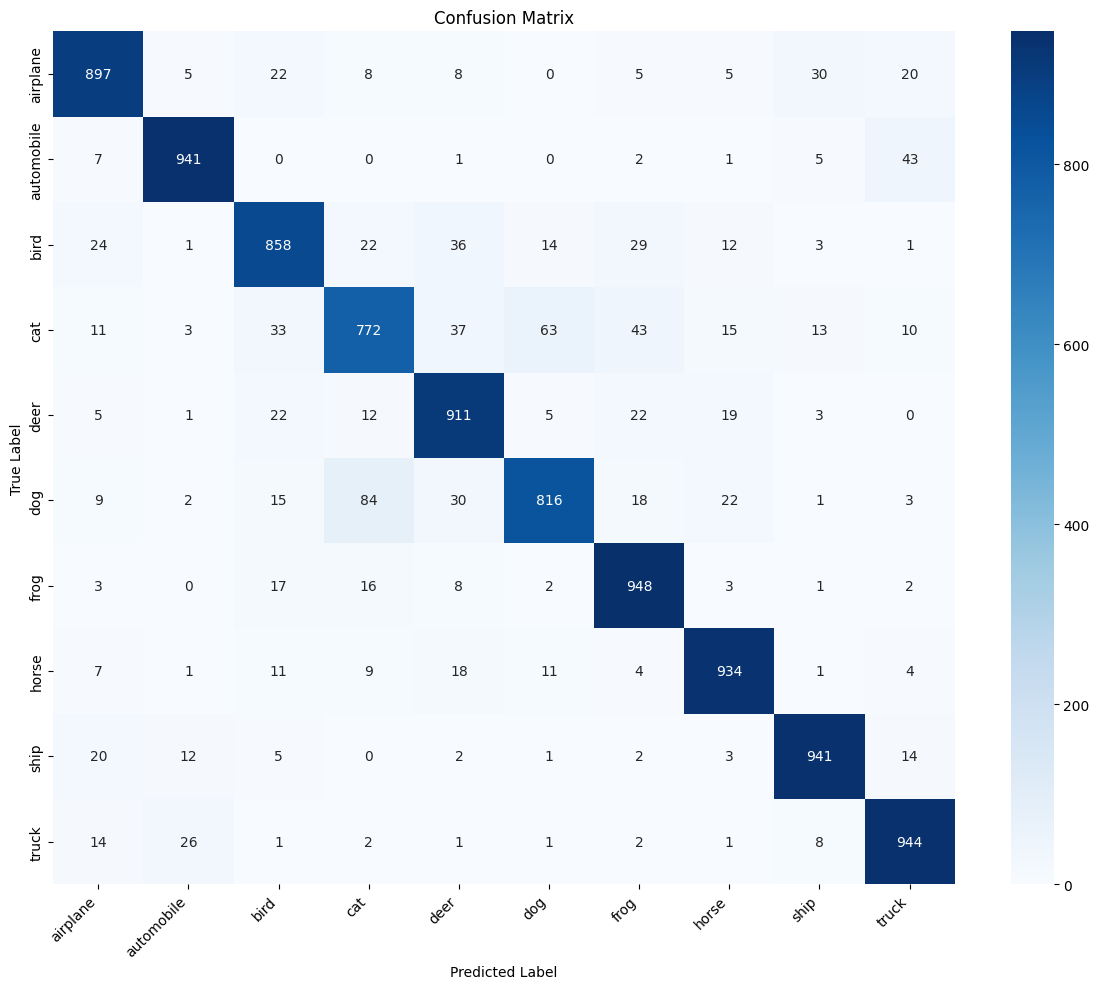


Classification Report:
              precision    recall  f1-score   support

    airplane       0.90      0.90      0.90      1000
  automobile       0.95      0.94      0.94      1000
        bird       0.87      0.86      0.86      1000
         cat       0.83      0.77      0.80      1000
        deer       0.87      0.91      0.89      1000
         dog       0.89      0.82      0.85      1000
        frog       0.88      0.95      0.91      1000
       horse       0.92      0.93      0.93      1000
        ship       0.94      0.94      0.94      1000
       truck       0.91      0.94      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



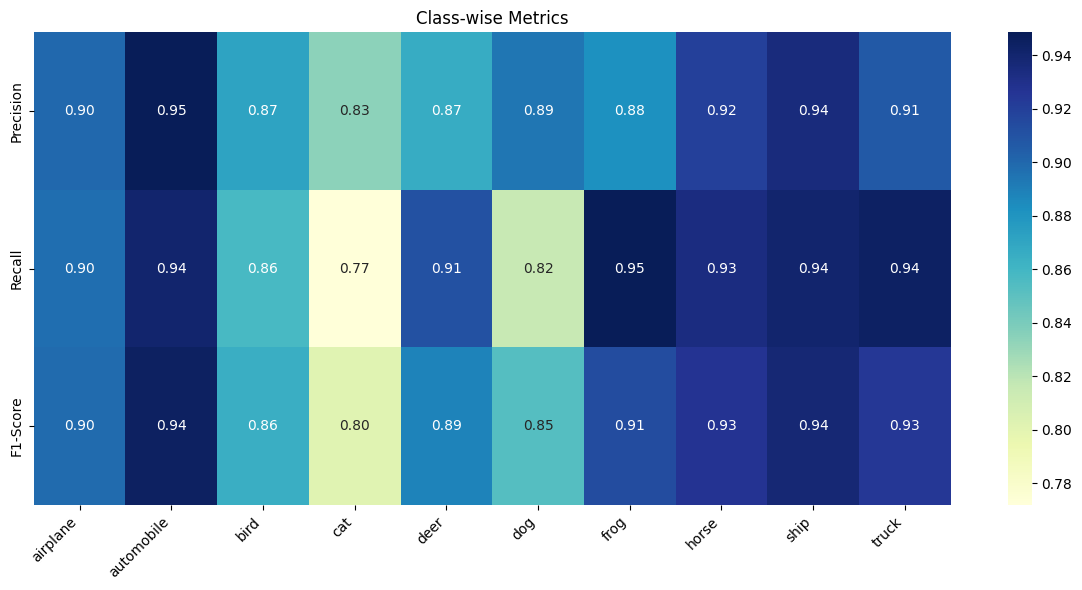

In [ ]:
def evaluate_model(model, x_test, y_test, class_names):
    """
    Evaluate the model and generate performance metrics
    
    Args:
        model: Trained Keras model
        x_test: Test images
        y_test: Test labels
        class_names: List of class names
    """
    # 1. Get predictions
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # 2. Confusion Matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 3. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # 4. Class-wise Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average=None)
    
    metrics = np.vstack([precision, recall, f1])
    plt.figure(figsize=(12, 6))
    sns.heatmap(metrics, annot=True, fmt='.2f', cmap='YlGnBu',
                xticklabels=class_names,
                yticklabels=['Precision', 'Recall', 'F1-Score'])
    plt.title('Class-wise Metrics')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
evaluate_model(model, x_test, y_test, class_names)

I0000 00:00:1748529178.223016  150973 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


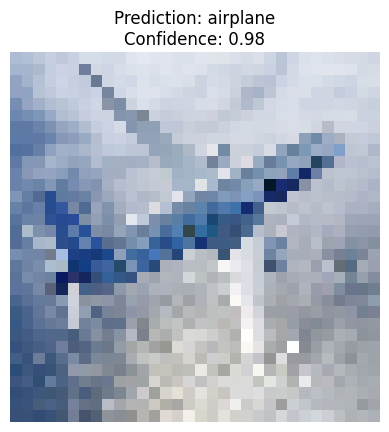

In [7]:
def predict_custom_image(model, img_path, class_names=None, target_size=(32, 32)):
    """
    Make a prediction on a single image.
    
    Args:
        model: Trained Keras model
        img_path: Path to the image file
        class_names: List of class names (optional)
        target_size: Size to resize the image to (should match model's expected input)
        
    Returns:
        Predicted class and confidence
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    # Get class name if available
    if class_names is not None:
        predicted_class_name = class_names[predicted_class]
    else:
        predicted_class_name = str(predicted_class)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {predicted_class_name}\nConfidence: {confidence:.2f}')
    plt.show()
    
    return predicted_class_name, float(confidence)

# Example usage:
# If you're using CIFAR-10, the class names are:
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']

# Replace 'path_to_your_image.jpg' with your image path
predicted_class, confidence = predict_custom_image(model, 'planes.jpg', class_names=cifar10_class_names)